In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Kohya Dreambooth Lora training

- In page training

- custom image loading in notebook

In [ ]:
! git clone --recurse-submodules https://github.com/Akegarasu/lora-scripts

In [ ]:
! git clone https://github.com/huggingface/diffusers.git

In [1]:
import subprocess
import os
import argparse
import re
import torch
from safetensors.torch import save_file

In [3]:
#Config accelerate
! accelerate config default
! cat /home/jupyter/.cache/huggingface/accelerate/default_config.yaml

{
  "compute_environment": "LOCAL_MACHINE",
  "distributed_type": "NO",
  "downcast_bf16": false,
  "machine_rank": 0,
  "main_training_function": "main",
  "mixed_precision": "no",
  "num_machines": 1,
  "num_processes": 1,
  "rdzv_backend": "static",
  "same_network": false,
  "tpu_use_cluster": false,
  "tpu_use_sudo": false,
  "use_cpu": false
}


In [53]:
#Change the parameters here
NUM_CPU_THREADS = 8
MODEL_NAME= "runwayml/stable-diffusion-v1-5"
INSTANCE_DIR= "/home/jupyter/dog_image"
METADATA_DIR = None
OUTPUT_DIR= "/home/jupyter/dog_output"
DISPLAY_NAME = "sks_dog"
RESOLUTION = "512,512"
MAX_EPOCHS = 10
LR = 1e-4
UNET_LR = 1e-4
TEXT_ENCODER_LR = 1e-5
LR_SCHEDULER = "cosine_with_restarts"
NETWORK_DIM = 32
NETWORK_ALPHA = 32
BATCH_SIZE = 1
SAVE_N_EPOCHS = 2
NETWORK_WEIGHTS = ""
REG_DIR = ""
USE_8BIT_ADAM = False
USE_LION = True
NOISE_OFFSET = 0

In [34]:
#Start training!
%cd /home/jupyter/lora-scripts
! accelerate launch --num_cpu_threads_per_process={NUM_CPU_THREADS} sd-scripts/train_network.py \
    --enable_bucket \
    --pretrained_model_name_or_path="{MODEL_NAME}" \
    --train_data_dir="{INSTANCE_DIR}" \
    --output_dir="{OUTPUT_DIR}" \
    --logging_dir="{OUTPUT_DIR}/logs" \
    --log_prefix="{DISPLAY_NAME}_logs" \
    --resolution="{RESOLUTION}" \
    --network_module="networks.lora" \
    --max_train_epochs={MAX_EPOCHS} \
    --learning_rate={LR} \
    --unet_lr={UNET_LR} \
    --text_encoder_lr={TEXT_ENCODER_LR} \
    --lr_scheduler="{LR_SCHEDULER}" \
    --lr_warmup_steps=0 \
    --lr_scheduler_num_cycles=1 \
    --network_dim={NETWORK_DIM} \
    --network_alpha={NETWORK_ALPHA} \
    --output_name="{DISPLAY_NAME}" \
    --train_batch_size={BATCH_SIZE} \
    --save_every_n_epochs={SAVE_N_EPOCHS} \
    --mixed_precision="fp16" \
    --save_precision="fp16" \
    --seed="1337" \
    --cache_latents \
    --clip_skip=2 \
    --prior_loss_weight=1 \
    --max_token_length=225 \
    --caption_extension=".txt" \
    --save_model_as="safetensors" \
    --min_bucket_reso=256 \
    --max_bucket_reso=1024 \
    --keep_tokens=0 \
    --xformers --shuffle_caption \
    --use_lion_optimizer \
    --noise_offset=0

/home/jupyter/lora-scripts
2023-04-13 17:59:55.516257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 17:59:56.113409: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-13 17:59:58.066453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-13 17:59:58

In [ ]:
#Merge lora and base model together
%cd /home/jupyter
! python diffusers/scripts/convert_lora_safetensor_to_diffusers.py \
    --base_model_path="runwayml/stable-diffusion-v1-5" \
    --checkpoint_path="/home/jupyter/dog_output/sks_dog.safetensors" \
    --dump_path="/home/jupyter/dog_output" \
    --alpha=1

  0%|          | 0/30 [00:00<?, ?it/s]

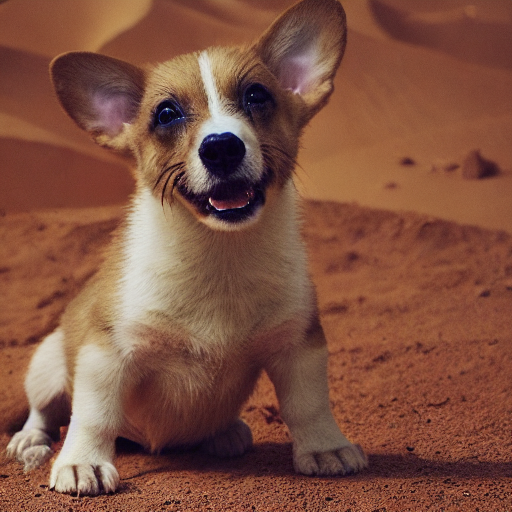

In [54]:
#Inference
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("/home/jupyter/dog_output")
pipeline.to("cuda")
pipeline("an image of dog, in the desert ", num_inference_steps=30).images[0]

In [ ]:
#upload the file to GCS
! gsutil cp /home/jupyter/dog_output/sks_dog.safetensors gs://YOUR_BUCKET_NAME/kohya_output/sks_dog.safetensors

### If you want to transfer the models to Filestore

In [ ]:
%%writefile vertex-config.yaml
network: projects/PROJECT_NUMBER/global/networks/VPC_NETWORK_NAME
workerPoolSpecs:
  machineSpec:
    machineType: n1-standard-4
  replicaCount: 1
  containerSpec:
    imageUri: us-central1-docker.pkg.dev/PROJECT_ID/ARTIFACT_REPOSITORY/sd-training:kohya
  nfsMounts:
    - server: NFS_IP_ADDRESS
      path: /vol1
      mountPoint: /mnt/nfs/model_repo


In [ ]:
# if you want to upload the models to NFS(FileStore)
# upload the model to GCS and then run the custom job to transfer the files
# Note that this command will copy all models in the folder to Filestore
! gcloud ai custom-jobs create  \
  --region=us-central1   \
  --display-name=copy-nfs   \
  --config=vertex-config.yaml   \
  --args="--output_storage=/gcs/YOUR_BUCKET/kohya_output,--save_nfs_only=True" \
  --command="python3,train_kohya.py"